In [1]:
# Miscelaneous.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as t
import cv2
import warnings
import shutil
import os

# Sklearn utils.
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

# Keras.
from keras.applications.resnet50 import ResNet50
from keras.applications import DenseNet169
from keras.utils import Sequence
from keras.layers import Dense, Dropout, Flatten, Input, ZeroPadding2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
os.listdir('../input/resnet')


['resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5']

In [3]:
PATH = '../input/'
PATH_APTOS = PATH + 'aptos2019-blindness-detection/'
PATH_2015 = PATH + 'retinopathy-train-2015/rescaled_train_896/'
#densenet_weights_path = PATH + 'densenet/densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet_weights_path = PATH + 'resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
PATH_AUGM = '/data_augm/'
HEIGHT, WIDTH = 256, 256
RANDOM_STATE = 974
VERBOSE = True
BATCH_SIZE = 32
DATA_AUGM = True
DATA_AUGM_FACTOR = 1
warnings.filterwarnings('ignore')

In [4]:
df_aptos = pd.read_csv(PATH_APTOS + 'train.csv')
df_aptos.rename(index=str, columns={"id_code": "id_code_aptos"}, inplace=True)

In [5]:
df_2015 = pd.read_csv(PATH_2015 + 'trainLabels.csv')
df_2015.rename(index=str, columns={"image": "id_code_2015", "level": "diagnosis"}, inplace=True)
df_2015 = df_2015.drop(df_2015[df_2015['diagnosis'] == 0].sample(frac=0.8).index)

In [6]:
df = df_aptos.append(df_2015)
df["data_augm"] = np.nan
if VERBOSE:
    display(df.head())
    print(df.shape)

diagnosis id_code_2015 id_code_aptos  data_augm
0          2          NaN  000c1434d8d7        NaN
1          4          NaN  001639a390f0        NaN
2          1          NaN  0024cdab0c1e        NaN
3          0          NaN  002c21358ce6        NaN
4          0          NaN  005b95c28852        NaN

(18140, 4)


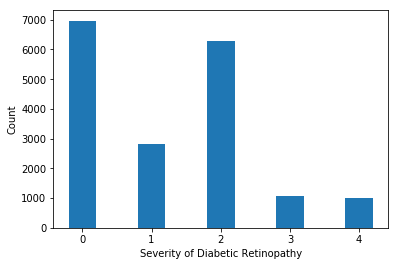

In [7]:
if VERBOSE:
    plt.hist(df.diagnosis, bins=[-0.2, 0.2, 0.8, 1.2, 1.8, 2.2, 2.8, 3.2, 3.8, 4.2])
    plt.xlabel("Severity of Diabetic Retinopathy")
    plt.ylabel("Count")
    plt.show()

In [8]:
def imagePreprocessing(image, normalize=True):
    # Cutting black border.
    row, col = image.shape[0], image.shape[1]
    center_row, center_col = row // 2, col // 2
    x_left, x_right, y_top, y_bot = 0, col, 0, row
    while image[center_row, x_left:x_left + 10].mean().max() <= 10  and x_left < col:
        x_left += 1
    while image[center_row, x_right - 10:x_right].mean().max() <= 10 and x_right > 0:
        x_right -= 1
    while image[y_top:y_top + 10, center_col].mean().max() <= 10 and y_top < row:
        y_top += 1
    while image[y_bot - 10:y_bot, center_col].mean().max() <= 10 and y_bot > 0:
        y_bot -= 1
    if y_top < y_bot and x_left < x_right and y_bot - y_top > 0.6 * row and x_right - x_left > 0.6 * col:
        image = image[y_top:y_bot, x_left:x_right]

    # Cutting to remove black corner.
    row, col = image.shape[0], image.shape[1]
    top_left_x, top_left_y = 0, 0
    while image[0, top_left_x:top_left_x + 10].mean().max() <= 10  and top_left_x < col:
        top_left_x += 1
    while image[top_left_y:top_left_y + 10, 0].mean().max() <= 10  and top_left_y < row:
        top_left_y += 1
    if 2 * np.abs(top_left_y - top_left_x) / (top_left_y + top_left_x) > 0.85 :
        crop_left_right = int(0.5 * top_left_x)
        if crop_left_right < 0.3 * col:
            image = image[:, crop_left_right:col - crop_left_right]
    else:
        crop = int(0.15 * (top_left_x + top_left_y) / 2)
        if crop < 0.3 * col and crop < 0.3 * row:
            image = image[crop:row - crop, crop:col - crop]
    
    # Resizing image.
    image = cv2.resize(image, (WIDTH, HEIGHT))
    
    # Applying GaussianBlur.
    blurred = cv2.blur(image, ksize=(int(WIDTH / 6), int(HEIGHT / 6)))
    image = cv2.addWeighted(image, 4, blurred, -4, 128)
    
    try:
        if normalize:
            image = image / 255
            image -= image.mean()
            return image
        else:
            return image
    except:
        return np.zeros((WIDTH, HEIGHT, 3))

In [9]:
def openImage(row, train=True, resize=False):
    image = None
    if not train:
        image = cv2.imread('{}test_images/{}.png'.format(PATH_APTOS, row.id_code))
    elif not pd.isnull(row.data_augm):
        image = cv2.imread(row.data_augm)
    elif not pd.isnull(row.id_code_aptos):
        image = cv2.imread('{}train_images/{}.png'.format(PATH_APTOS, row.id_code_aptos))
    elif not pd.isnull(row.id_code_2015):
        image = cv2.imread('{}rescaled_train_896/{}.png'.format(PATH_2015, row.id_code_2015))
    else:
        print("[Error] Could not open the image. Log: {}".format(row))
    if resize and not image is None:
        return cv2.resize(image, (WIDTH, HEIGHT))
    return image

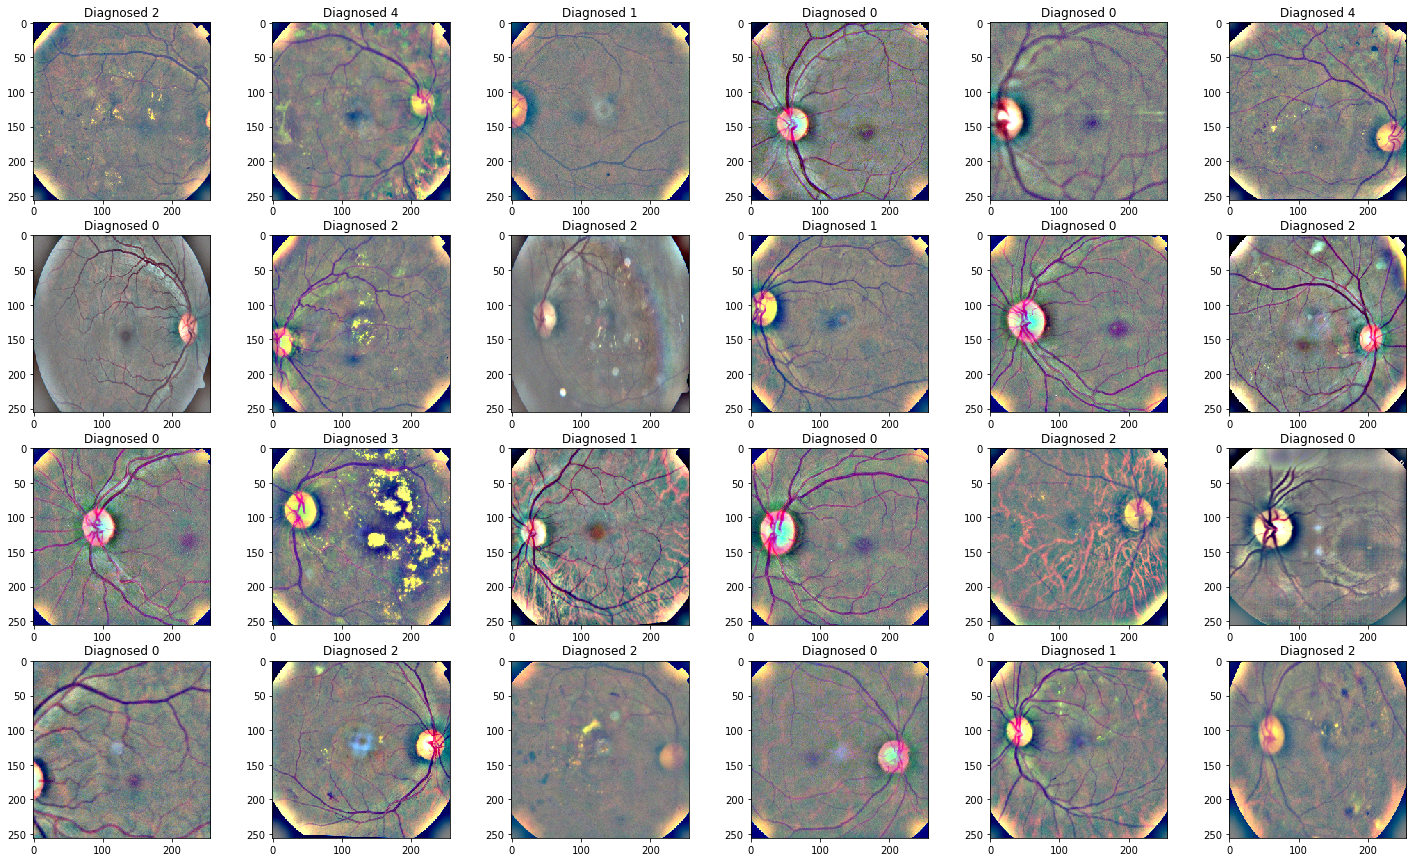

In [10]:
if VERBOSE:
    nb_row = 4
    nb_col = 6
    nb = 1
    plt.figure(figsize=(25, 15))
    for row in df.itertuples():
        if nb > nb_col * nb_row:
            break
        plt.subplot(nb_row, nb_col, nb)
        plt.imshow(cv2.cvtColor(imagePreprocessing(openImage(row), normalize=False), cv2.COLOR_BGR2RGB))
        plt.title('Diagnosed {}'.format(row.diagnosis))
        nb += 1
    plt.show()

In [11]:
class RetinaGenerator():
    def __init__(self, image_df, batch_size, train=True):
        self.image_df = image_df
        self.batch_size = batch_size
        self.train = train
        self.step_per_epoch = len(self.image_df) // self.batch_size
        self.step_per_pred = 1 + (len(self.image_df) - 1) // self.batch_size
    def getGenerator(self):
        while True:
            for idx in range(self.step_per_epoch):
                batch_x = np.array([imagePreprocessing(openImage(row)) for row in self.image_df[idx * self.batch_size:(idx + 1) * self.batch_size].itertuples()])
                batch_y_cat= to_categorical([row.diagnosis for row in self.image_df[idx * self.batch_size:(idx + 1) * self.batch_size].itertuples()], num_classes=5)
                batch_y = np.empty(batch_y_cat.shape, dtype=batch_y_cat.dtype)
                batch_y[:, 4] = batch_y_cat[:, 4]
                for i in range(3, -1, -1):
                    batch_y[:, i] = np.logical_or(batch_y_cat[:, i], batch_y[:, i+1])
                yield batch_x, batch_y
    def getInputGenerator(self):
        for idx in range(self.step_per_pred + 1):
            yield np.array([imagePreprocessing(openImage(row, self.train)) for row in self.image_df[idx * self.batch_size:min((idx + 1) * self.batch_size, len(self.image_df))].itertuples()])

In [12]:
if DATA_AUGM:
    shutil.rmtree(PATH_AUGM, ignore_errors=True, onerror=None)
    shutil.os.mkdir(PATH_AUGM)
    df = shuffle(df, random_state=RANDOM_STATE)
    max_size = int(df.diagnosis.value_counts().max() * DATA_AUGM_FACTOR)
    for diag in range(5):
        shutil.rmtree('{}diag_{}'.format(PATH_AUGM, diag), ignore_errors=True, onerror=None)
        shutil.os.mkdir('{}diag_{}'.format(PATH_AUGM, diag))
        diag_df = df[df.diagnosis == diag]
        size = len(diag_df)
        to_create = max_size - size
        augm_per_img = max(to_create // size, 1)
        while to_create > 0:
            for row in diag_df.itertuples():
                if to_create < 0:
                    break
                image = np.expand_dims(cv2.cvtColor(openImage(row, resize=True), cv2.COLOR_BGR2RGB), 0)
                data_generator = ImageDataGenerator(rotation_range=360, vertical_flip=True, horizontal_flip=True, zoom_range=0.1)
                data_generator.fit(image)
                id_code = row.id_code_aptos if not pd.isnull(row.id_code_aptos) else row.id_code_2015
                for x, val in zip(data_generator.flow(image, save_to_dir='{}diag_{}'.format(PATH_AUGM, diag), 
                                                      save_prefix=id_code, save_format='png'), 
                                  range(augm_per_img - 1)):
                    pass
                to_create -= augm_per_img
    for diag in range(5):
        images = np.array(os.listdir("{}diag_{}".format(PATH_AUGM, diag)))
        for image in images:#diagnosis	id_code_2015	id_code_aptos	data_augm
            df = df.append(pd.DataFrame([[diag, np.nan, np.nan, "{}diag_{}/{}".format(PATH_AUGM, diag, image)]], columns=df.columns))
    df = shuffle(df, random_state=RANDOM_STATE)
    display(df.head())

diagnosis id_code_2015 id_code_aptos  \
177           1          NaN  0d310aba6373   
2634          2    3301_left           NaN   
0             4          NaN           NaN   
0             4          NaN           NaN   
0             3          NaN           NaN   

                                      data_augm  
177                                         NaN  
2634                                        NaN  
0     /data_augm/diag_4/ef26625121b3_0_2645.png  
0       /data_augm/diag_4/29839_left_0_9944.png  
0      /data_augm/diag_3/40922_right_0_3375.png

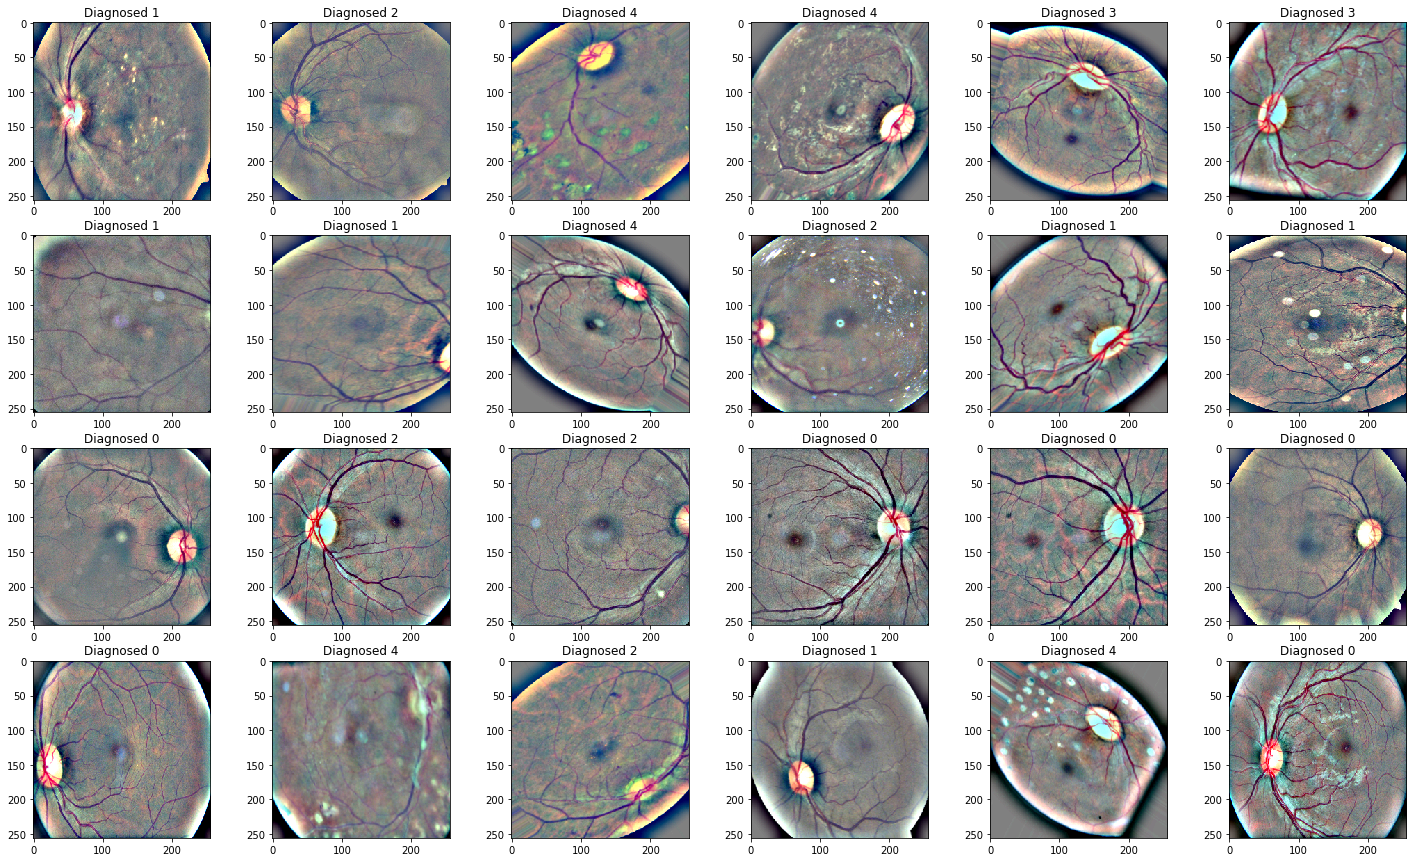

In [13]:
if VERBOSE:
    nb_row = 4
    nb_col = 6
    nb = 1
    plt.figure(figsize=(25, 15))
    for row in df.itertuples():
        if nb > nb_col * nb_row:
            break
        plt.subplot(nb_row, nb_col, nb)
        plt.imshow(cv2.cvtColor(imagePreprocessing(openImage(row), normalize=False), cv2.COLOR_BGR2RGB))
        plt.title('Diagnosed {}'.format(row.diagnosis))
        nb += 1
    plt.show()

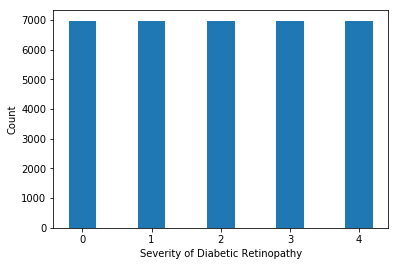

(34840, 4)


In [14]:
if VERBOSE:
    plt.hist(df.diagnosis, bins=[-0.2, 0.2, 0.8, 1.2, 1.8, 2.2, 2.8, 3.2, 3.8, 4.2])
    plt.xlabel("Severity of Diabetic Retinopathy")
    plt.ylabel("Count")
    plt.show()
    print(df.shape)

In [15]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=RANDOM_STATE)
if VERBOSE:
    print(train_df.shape, val_df.shape, test_df.shape)

(22297, 4) (6968, 4) (5575, 4)


In [16]:
LEARNING_RATE = 0.005
EPOCHS = 3
PATIENCE = 3
LR_PATIENCE =3
VALIDATION_GENERATOR = RetinaGenerator(val_df, BATCH_SIZE)
TRAINING_GENERATOR = RetinaGenerator(train_df, BATCH_SIZE)
ALL_GENERATOR = RetinaGenerator(df, BATCH_SIZE)
STEPS_PER_EPOCH = TRAINING_GENERATOR.step_per_epoch
VALIDATION_STEPS = VALIDATION_GENERATOR.step_per_epoch

In [17]:
visible = Input(shape=(HEIGHT, WIDTH, 3))

resnet = ResNet50(
    include_top=False,
    weights=None,
    input_tensor=visible,
)
resnet.load_weights(resnet_weights_path)


model = Sequential()

model.add(resnet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))
    
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=0.00005),
    metrics=['accuracy']
)
print(model.summary())



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________
None


In [18]:
opt = optimizers.SGD(lr=LEARNING_RATE, decay=1e-6, momentum=0.9, nesterov=True)

Callbacks=[EarlyStopping(patience=PATIENCE, restore_best_weights=True), 
           ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=VERBOSE)]
with tf.device('/device:GPU:0'):
    H = model.fit_generator(generator=TRAINING_GENERATOR.getGenerator(),
                            validation_data=VALIDATION_GENERATOR.getGenerator(),
                            steps_per_epoch=STEPS_PER_EPOCH,
                            validation_steps=VALIDATION_STEPS,
                            epochs=EPOCHS,
                            callbacks=Callbacks,
                            verbose=VERBOSE)

Epoch 1/3
696/696 [==============================] - 1031s 1s/step - loss: 0.2760 - accuracy: 0.8700 - val_loss: 0.4992 - val_accuracy: 0.7932
Epoch 2/3
696/696 [==============================] - 940s 1s/step - loss: 0.1692 - accuracy: 0.9261 - val_loss: 0.3089 - val_accuracy: 0.9055
Epoch 3/3
696/696 [==============================] - 952s 1s/step - loss: 0.0832 - accuracy: 0.9670 - val_loss: 0.2671 - val_accuracy: 0.8977


In [19]:
from sklearn.metrics import accuracy_score, cohen_kappa_score

if VERBOSE:
    TEST_GENERATOR = RetinaGenerator(test_df, BATCH_SIZE)
    STEPS = TEST_GENERATOR.step_per_pred
    Y_pred = (model.predict_generator(TEST_GENERATOR.getInputGenerator(), steps=STEPS) > 0.5).sum(axis=1) - 1
    Y_test = np.array(test_df.diagnosis)
    print("Average absolute distance is: {:.2f}".format(np.abs(Y_pred - Y_test).mean()))
    display(confusion_matrix(Y_test, Y_pred))
    print("Accuracy Score:" + str(accuracy_score(Y_test, Y_pred)))
    print("Cohen Kappa Score:" + str(cohen_kappa_score(Y_test, Y_pred, weights='quadratic')))
    

Average absolute distance is: 0.53


array([[917, 186,  50,   4,   3],
       [244, 580, 106, 111,  54],
       [224, 247, 490, 149,  61],
       [  2,  51,  89, 462, 500],
       [  4,  20,  33,  97, 891]])

Accuracy Score:0.5991031390134529
Cohen Kappa Score:0.8136520690981807


In [20]:
STEPS = ALL_GENERATOR.step_per_pred
Y_pred = model.predict_generator(ALL_GENERATOR.getInputGenerator(), steps=STEPS)
Y_true = to_categorical(np.array(df.diagnosis), 5)

In [21]:
Y_true.shape

(34840, 5)

In [22]:
post_model = Sequential()
post_model.add(Dense(5, input_dim=5, activation='relu'))
post_model.add(Dense(5, activation='softmax'))
post_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
opt = optimizers.SGD(lr=LEARNING_RATE, decay=1e-6, momentum=0.9, nesterov=True)

Callbacks=[EarlyStopping(patience=PATIENCE, restore_best_weights=True), 
           ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=VERBOSE)]
with tf.device('/device:GPU:0'):
    H = post_model.fit(Y_pred, Y_true, batch_size=10, epochs=50, verbose=VERBOSE )


Epoch 1/50
34840/34840 [==============================] - 8s 230us/step - loss: 1.1475 - accuracy: 0.5644
Epoch 2/50
34840/34840 [==============================] - 8s 236us/step - loss: 0.8493 - accuracy: 0.7387
Epoch 3/50
34840/34840 [==============================] - 8s 234us/step - loss: 0.7689 - accuracy: 0.7492
Epoch 4/50
34840/34840 [==============================] - 9s 247us/step - loss: 0.7453 - accuracy: 0.7525
Epoch 5/50
34840/34840 [==============================] - 8s 226us/step - loss: 0.7349 - accuracy: 0.7534
Epoch 6/50
34840/34840 [==============================] - 8s 234us/step - loss: 0.7286 - accuracy: 0.7554
Epoch 7/50
34840/34840 [==============================] - 8s 233us/step - loss: 0.7246 - accuracy: 0.7559
Epoch 8/50
34840/34840 [==============================] - 9s 246us/step - loss: 0.7214 - accuracy: 0.7563
Epoch 9/50
34840/34840 [==============================] - 8s 226us/step - loss: 0.7190 - accuracy: 0.7576
Epoch 10/50
34840/34840 [=====================

In [23]:
sub_df = pd.read_csv(PATH_APTOS + 'test.csv')
if VERBOSE:
    print(sub_df.shape)
    display(sub_df.head())

(1928, 1)


id_code
0  0005cfc8afb6
1  003f0afdcd15
2  006efc72b638
3  00836aaacf06
4  009245722fa4

In [24]:
SUB_GENERATOR = RetinaGenerator(sub_df, BATCH_SIZE, False)
STEPS = SUB_GENERATOR.step_per_pred
Y_sub_preview = model.predict_generator(SUB_GENERATOR.getInputGenerator(), steps=STEPS)
Y_sub_cat = post_model.predict(Y_sub_preview)
Y_sub = np.argmax(Y_sub_cat, axis=1)
#Y_sub = np.argmax(model.predict_generator(SUB_GENERATOR.getInputGenerator(), steps=STEPS), axis=1)
if VERBOSE:
    print(Y_sub.shape)

(1928,)


In [25]:
Y_sub

array([2, 3, 3, ..., 3, 3, 3])

In [26]:
sub_df['diagnosis'] = Y_sub
if VERBOSE:
    print(sub_df.shape)
    display(sub_df)

(1928, 2)


id_code  diagnosis
0     0005cfc8afb6          2
1     003f0afdcd15          3
2     006efc72b638          3
3     00836aaacf06          2
4     009245722fa4          2
...            ...        ...
1923  ff2fd94448de          0
1924  ff4c945d9b17          2
1925  ff64897ac0d8          3
1926  ffa73465b705          3
1927  ffdc2152d455          3

[1928 rows x 2 columns]

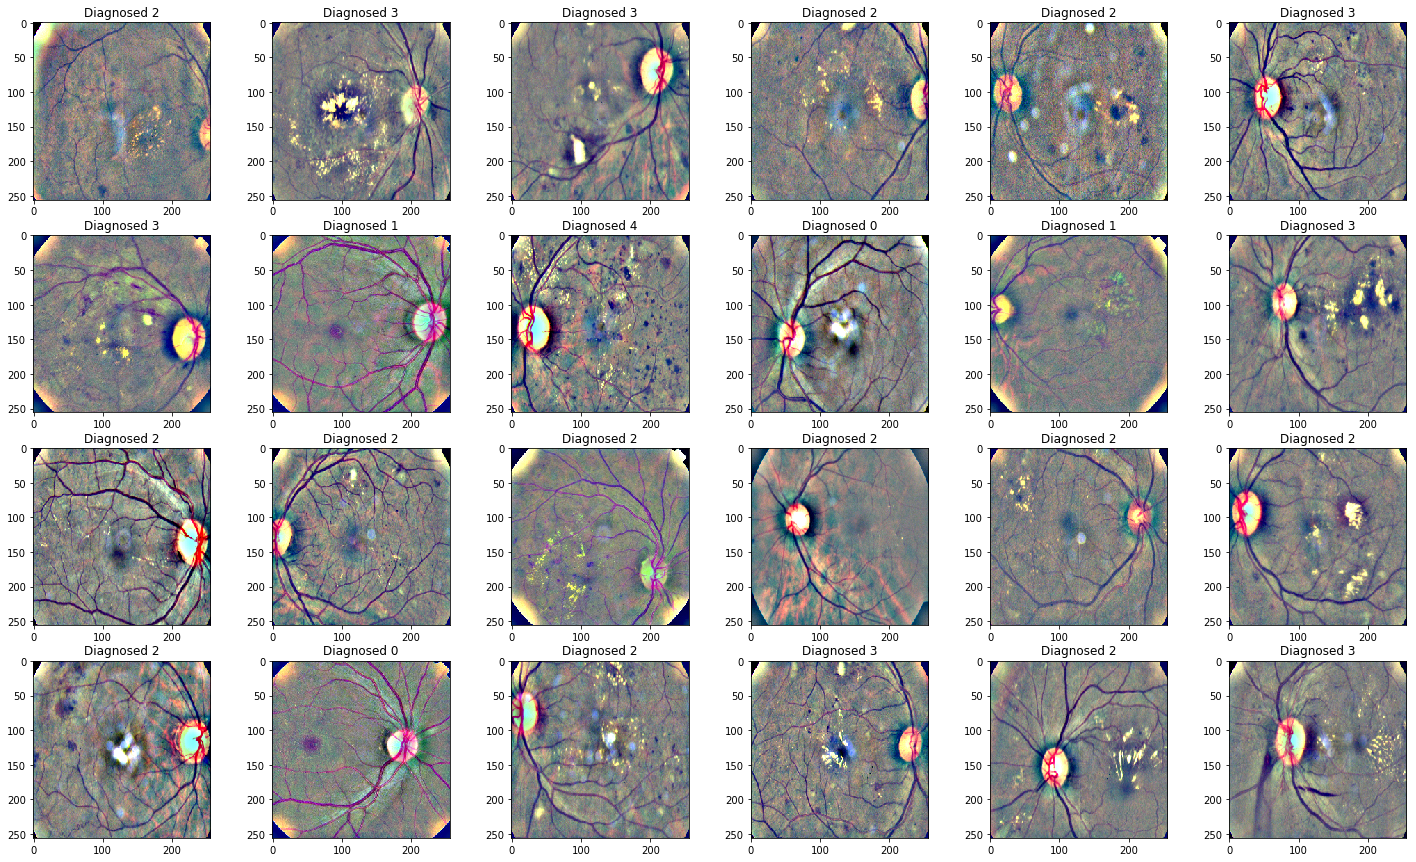

In [27]:
if VERBOSE:
    nb_row = 4
    nb_col = 6
    nb = 1
    plt.figure(figsize=(25, 15))
    for row in sub_df.itertuples():
        if nb > nb_col * nb_row:
            break
        plt.subplot(nb_row, nb_col, nb)
        plt.imshow(cv2.cvtColor(imagePreprocessing(openImage(row, False), normalize=False), cv2.COLOR_BGR2RGB))
        plt.title('Diagnosed {}'.format(row.diagnosis))
        nb += 1
    plt.show()

In [28]:
sub_df.to_csv('submission.csv', index=False)

In [29]:
model.save('model1.h5')
post_model.save('model2.h5')